In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
# from sqlalchemy import create_engine
# from sqlalchemy_utils import database_exists, create_database
import psycopg2

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
#Connect to db
dbname = 'beforeiagree_db'
username = 'peterostendorp'

#Create engine
con = psycopg2.connect(database = dbname, user = username)

In [5]:
sql = """
SELECT * FROM annotations;
"""
annotations = pd.read_sql_query(sql,con)

## Policy-level features

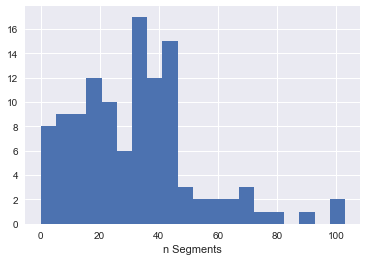

In [15]:
#POTENTIAL FEATURE: NUMBER OF SEGMENTS
#Distribution of segments across policies
annotations.groupby('Policy UID').max()['segment_id'].hist(bins=20)
plt.xlabel('n Segments')

In [11]:
sql = """
SELECT * FROM sites;
"""
sites = pd.read_sql_query(sql,con)

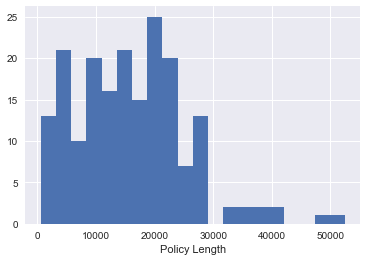

In [16]:
#POTENTIAL FEATURE: POLICY LENGTH
#Policy lengths based on string character count
sites['policy_text'].apply(len).hist(bins = 20)
plt.xlabel('Policy Length')

## Segment-level features

In [155]:
sql = """
SELECT * FROM segments
"""

segments = pd.read_sql_query(sql,con)

In [19]:
segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6469 entries, 0 to 6468
Data columns (total 3 columns):
Policy UID    6469 non-null int64
segment_id    6469 non-null int64
segments      6469 non-null object
dtypes: int64(2), object(1)
memory usage: 151.7+ KB


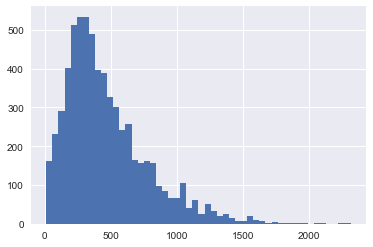

In [22]:
#POTENTIAL FEATURE: CONTAINING SEGMENT LENGTH
segments['segments'].apply(len).hist(bins=50)

## Messing with bigrams

In [29]:
from nltk.util import bigrams
string = "I really like python, it's pretty awesome."
string_bigrams = bigrams(string.split())
for gram in string_bigrams:
    print(gram)

('I', 'really')
('really', 'like')
('like', 'python,')
('python,', "it's")
("it's", 'pretty')
('pretty', 'awesome.')


## More formal text processing

In [52]:
from nltk.corpus import stopwords
import re

In [55]:
def text_process(seg):
    """
    1. remove stopwords
    2. remove HTML tags
    """
    lst = [word for word in seg.split() if word.lower() not in stopwords.words('english')]
    return [word for word in lst if re.search(r'\<.*\>',word) is None]

In [57]:
segments['segments'].head().apply(text_process)

0    [Privacy, Policy, Effective:, January, 1,, 201...
1    [privacy, policy, apply, Sites, maintained, co...
2    [visiting, Sites,, accepting, practices, descr...
3    [Information, Collected?, collect, two, basic,...
4    [Personally, Identifiable, Information, genera...
Name: segments, dtype: object

## Setting up a bag of words model

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

In [59]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(segments['segments'])

In [60]:
#How many words?
print(len(bow_transformer.vocabulary_))

13980


In [67]:
#Now create the transformer for our set of segments
segment_bow = bow_transformer.transform(segments['segments'])

In [68]:
#Some info on our transformer matrix
print(segment_bow.shape)
print(segment_bow.nnz)

(6469, 13980)
213177


In [64]:
#Normalized vectors with TF-IDF transformer
from sklearn.feature_extraction.text import TfidfTransformer

In [69]:
tfidf_transformer = TfidfTransformer().fit(segment_bow)

In [71]:
segments_tfidf = tfidf_transformer.transform(segment_bow)

## Creating a simple Naive-Bayes binary classifier
First need to develop a binary target. Our categories are multinomial, but we can use a one-hot encoding for target. Let's see what targets we have to choose from.

**Lots of nonsense dealing with sites not in the original set... maybe I should split this stuff out into another table earlier?**

In [74]:
annotations['category_name'].unique()

array(['Other', 'First Party Collection/Use', 'Data Retention',
       'International and Specific Audiences', 'User Choice/Control',
       'Third Party Sharing/Collection', 'User Access, Edit and Deletion',
       'Policy Change', 'Data Security', 'Do Not Track'], dtype=object)

In [183]:
#Join category name to segments and determine the mode of each category, concat back onto original segments
tmp = segments.join(annotations.set_index(['Policy UID','segment_id'])['category_name'],on=['Policy UID','segment_id'],how='outer')
tmp['category_name'] = tmp['category_name'].fillna(value='None')
tmp2 = tmp.groupby(by=['Policy UID','segment_id'])['category_name'].agg(lambda x: x.value_counts().index[0])

In [188]:
segments = segments.join(pd.DataFrame(tmp2),on=['Policy UID','segment_id'],how='outer')

In [189]:
one_hot_data_retention = lambda s: 1 if s.startswith('Data Retention') else 0

In [190]:
#Define a new column with one-hot encoding of Data Retention policy for our target
segments['data_retention'] = segments['category_name'].apply(one_hot_data_retention)

In [223]:
#Which sites in the original 115?
#df = df[~df['date'].isin(a)]
pids_115 = list(sites['Policy UID'][sites['In 115 Set?']])
segments = segments[segments['Policy UID'].isin(pids_115)]


**Here we finally get to building the model**

In [225]:
from sklearn.naive_bayes import MultinomialNB

In [226]:
data_retention_model = MultinomialNB().fit(segments_tfidf,segments['data_retention'])

Some simple predictions...

In [232]:
#Original segment
seg4 = segments['segments'][3]
print(seg4)

<strong> What Information Is Collected? </strong> <br> <br> We collect two basic types of information from you in conjunction with your use of the Sites: non-personally identifiable information and personally identifiable information. Non-personally identifiable information does not individually identify you, but it may include tracking and usage information about your general location, demographics, use of the Sites and the Internet. Personally identifiable information is any information that can individually identify you and includes, your name, address, phone number, and email address, or non-personally identifiable information that has been linked to such personally identifiable information. <br> <br>


In [233]:
bow4 = bow_transformer.transform([seg4])
print(bow4)

  (0, 2007)	1
  (0, 2962)	1
  (0, 3030)	1
  (0, 3567)	1
  (0, 3851)	1
  (0, 4488)	1
  (0, 4497)	1
  (0, 5388)	2
  (0, 6057)	1
  (0, 6609)	1
  (0, 6840)	1
  (0, 7341)	1
  (0, 7791)	1
  (0, 8480)	1
  (0, 8925)	6
  (0, 8945)	2
  (0, 9039)	1
  (0, 9045)	1
  (0, 9098)	2
  (0, 9124)	7
  (0, 9140)	2
  (0, 9612)	1
  (0, 9676)	1
  (0, 9868)	1
  (0, 10080)	1
  (0, 10203)	2
  (0, 10262)	1
  (0, 10836)	2
  (0, 10861)	1
  (0, 13173)	1
  (0, 13293)	1
  (0, 13297)	1
  (0, 13430)	1
  (0, 13434)	2
  (0, 13958)	1


In [234]:
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 13958)	0.0937056314045
  (0, 13434)	0.0917158626698
  (0, 13430)	0.104791423416
  (0, 13297)	0.107994290499
  (0, 13293)	0.128014180804
  (0, 13173)	0.113367551928
  (0, 10861)	0.114533479865
  (0, 10836)	0.1609563979
  (0, 10262)	0.110859273134
  (0, 10203)	0.25255635262
  (0, 10080)	0.09107270343
  (0, 9868)	0.0383252335442
  (0, 9676)	0.130691461205
  (0, 9612)	0.121474991438
  (0, 9140)	0.143727799593
  (0, 9124)	0.22961851354
  (0, 9098)	0.327774597958
  (0, 9045)	0.145649473187
  (0, 9039)	0.0933103064611
  (0, 8945)	0.195223785592
  (0, 8925)	0.495761019941
  (0, 8480)	0.112078832109
  (0, 7791)	0.0738722529683
  (0, 7341)	0.185606658225
  (0, 6840)	0.141374931009
  (0, 6609)	0.0610094509147
  (0, 6057)	0.152986309703
  (0, 5388)	0.168502285181
  (0, 4497)	0.185606658225
  (0, 4488)	0.103775361024
  (0, 3851)	0.122301650222
  (0, 3567)	0.174923188421
  (0, 3030)	0.13467395725
  (0, 2962)	0.061740278018
  (0, 2007)	0.197218036919


In [236]:
data_retention_model.predict(tfidf4)[0]

0

In [237]:
segments['data_retention'][3]

0

Eureka!!! Now predict for all...

In [238]:
preds = data_retention_model.predict(segments_tfidf)

## Train-test split for the data

In [241]:
from sklearn.model_selection import train_test_split

In [242]:
seg_train,seg_test,cat_train,cat_test = train_test_split(segments['segments'],segments['data_retention'],
                                                         test_size = 0.2, random_state = 101)

## Creating a pipeline for the whole damn thing

In [239]:
from sklearn.pipeline import Pipeline

In [243]:
data_retention_pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [244]:
data_retention_pipeline.fit(seg_train,cat_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x115111c80>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [245]:
preds = data_retention_pipeline.predict(seg_test)

In [246]:
from sklearn.metrics import classification_report, confusion_matrix

In [247]:
print(confusion_matrix(cat_test,preds))
print(classification_report(cat_test,preds))

[[1281    0]
 [  13    0]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1281
          1       0.00      0.00      0.00        13

avg / total       0.98      0.99      0.98      1294



/Users/peterostendorp/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
